Modeling with neural networks
---

# imports

In [74]:
# import libraries
import os
import numpy as np
import pandas as pd
import datetime as dt
from dateutil import tz

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist
from tensorflow.keras import callbacks

#pkerastting
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors


In [2]:
processed_data_path = '../processed_data/processed_data.csv'
ts_df = pd.read_csv(processed_data_path, index_col='created_at', parse_dates=True)

In [3]:
ts_df.columns

Index(['language_is_English', 'language_is_Japanese', 'language_is_Spanish',
       'language_is_Turkish', 'language_is_French', 'language_is_Korean',
       'language_is_German', 'language_is_Catalan', 'language_is_Russian',
       'language_is_Estonian',
       ...
       'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16',
       'lag_17', 'lag_18', 'lag_19'],
      dtype='object', length=113)

<AxesSubplot:xlabel='created_at'>

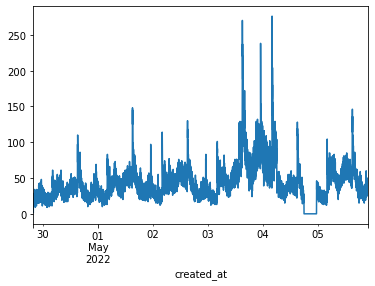

In [4]:
ts_df['total_tweets'].plot()

Create training and testing sets. Train for all values 1 day after start, up to the gap at the end of May 4. The first missing value in the stretch is at May 4, 17:58:00 the last missing value is at May 4, 23:26:00.

In [5]:
#train before gap
train = ts_df[ts_df.index < dt.datetime(2022, 5, 4, 17, 58, 0, tzinfo = tz.UTC )].dropna()

#test after gap
test = ts_df[ts_df.index > dt.datetime(2022, 5, 4, 23, 58, 0, tzinfo = tz.UTC )].dropna()

<AxesSubplot:xlabel='created_at'>

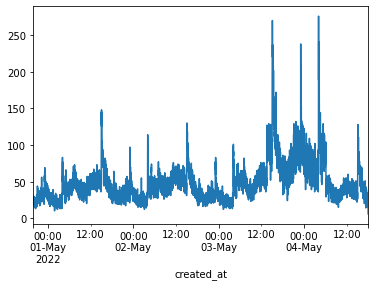

In [6]:
train['total_tweets'].plot()

<AxesSubplot:xlabel='created_at'>

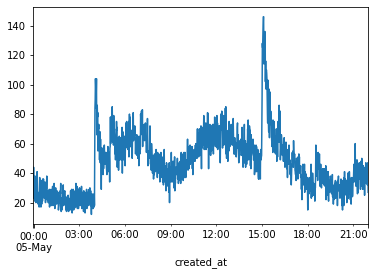

In [7]:
test['total_tweets'].plot()

# Split data into training and validation sets

In [112]:
#assign target columns
targets = ['total_tweets', 'is_wordle']
# manual train-test-split
X_train = train.drop(columns = targets).copy()
X_test = test.drop(columns = targets).copy()
y_train = train[targets].copy()
y_test = test[targets].copy()

#put is_wordle fraction on the same scale as the 'total_tweets'
y_test['is_wordle'] = y_test['total_tweets']*y_test['is_wordle']
y_train['is_wordle'] = y_train['total_tweets']*y_train['is_wordle']

# create NNs

give the NN a choice of

    - number of minutes before 10 before
    - number of minutes up to ten, around day-before-value
    - number of top languages to monitor
    - number of top games to monitor
    - number of top locations to monitor
    - layer depth of network
    - size of each layer

In [113]:
language_columns = X_train.columns[:25].to_list()
language_columns

['language_is_English',
 'language_is_Japanese',
 'language_is_Spanish',
 'language_is_Turkish',
 'language_is_French',
 'language_is_Korean',
 'language_is_German',
 'language_is_Catalan',
 'language_is_Russian',
 'language_is_Estonian',
 'language_is_Thai',
 'language_is_Tagalog',
 'language_is_Dutch',
 'language_is_Czech',
 'language_is_Portuguese',
 'language_is_Indonesian',
 'language_is_Chinese',
 'language_is_Finnish',
 'language_is_Norwegian',
 'language_is_Romanian',
 'language_is_Italian',
 'language_is_Arabic',
 'language_is_Danish',
 'language_is_Welsh',
 'language_is_Swedish']

In [114]:
games_columns = X_train.columns[25:28+25].to_list()
games_columns

['game_from_hashtag_ポケモンWordle',
 'game_from_hashtag_Wordle',
 'game_from_hashtag_wordle',
 'game_from_hashtag_WordleCAT',
 'game_from_hashtag_вордли',
 'game_from_hashtag_Heardle',
 'game_from_hashtag_워들',
 'game_from_hashtag_한글',
 'game_from_hashtag_Korean',
 'game_from_hashtag_wordleTR',
 'game_from_hashtag_AlWird',
 'game_from_hashtag_galego',
 'game_from_hashtag_WordleGalego',
 'game_from_hashtag_DailyWordleClub',
 'game_from_hashtag_WordleEnglish',
 'game_from_hashtag_WordleEN',
 'game_from_hashtag_WordleEUS',
 'game_from_hashtag_hadesjSlova',
 'game_from_hashtag_WORDLE_TAMIL',
 'game_from_hashtag_WizardingWordle',
 'game_from_hashtag_Enstarsdle',
 'game_from_hashtag_WordleEspañol',
 'game_from_hashtag_wordleES',
 'game_from_hashtag_嘘wordle',
 'game_from_hashtag_百人一首Wordle',
 'game_from_hashtag_Quordle',
 'game_from_hashtag_ことのはたんご',
 'game_from_hashtag_NYTimes']

In [115]:
location_columns = X_train.columns[25+28:25+53].to_list()
location_columns

['broad_location_is_USAE',
 'broad_location_is_UK',
 'broad_location_is_JPN',
 'broad_location_is_ES',
 'broad_location_is_USAC',
 'broad_location_is_USA',
 'broad_location_is_USAW',
 'broad_location_is_IN',
 'broad_location_is_ASTL',
 'broad_location_is_CAE',
 'broad_location_is_AR',
 'broad_location_is_USAM',
 'broad_location_is_IE',
 'broad_location_is_TK',
 'broad_location_is_CA',
 'broad_location_is_MX',
 'broad_location_is_PH',
 'broad_location_is_NZ',
 'broad_location_is_CL',
 'broad_location_is_SA',
 'broad_location_is_EUR',
 'broad_location_is_CAW',
 'broad_location_is_MY',
 'broad_location_is_CAM',
 'broad_location_is_CO']

In [116]:
time_columns = X_train.columns[53+25:55+25].to_list()
time_columns

['minute', 'hour']

In [117]:
lag_day_columns = X_train.columns[55+25:65+36].to_list()
lag_day_columns

['lag_day_-10',
 'lag_day_-9',
 'lag_day_-8',
 'lag_day_-7',
 'lag_day_-6',
 'lag_day_-5',
 'lag_day_-4',
 'lag_day_-3',
 'lag_day_-2',
 'lag_day_-1',
 'lag_day_0',
 'lag_day_1',
 'lag_day_2',
 'lag_day_3',
 'lag_day_4',
 'lag_day_5',
 'lag_day_6',
 'lag_day_7',
 'lag_day_8',
 'lag_day_9',
 'lag_day_10']

These need to be reordered to start with 0, then +-1, then +-2, etc.

In [118]:
lag_day_columns = ['lag_day_0']
for lag in range(1,11):
    lag_day_columns.append(f'lag_day_{lag}')
    lag_day_columns.append(f'lag_day_-{lag}')
lag_day_columns

['lag_day_0',
 'lag_day_1',
 'lag_day_-1',
 'lag_day_2',
 'lag_day_-2',
 'lag_day_3',
 'lag_day_-3',
 'lag_day_4',
 'lag_day_-4',
 'lag_day_5',
 'lag_day_-5',
 'lag_day_6',
 'lag_day_-6',
 'lag_day_7',
 'lag_day_-7',
 'lag_day_8',
 'lag_day_-8',
 'lag_day_9',
 'lag_day_-9',
 'lag_day_10',
 'lag_day_-10']

In [119]:
lag_columns = X_train.columns[65+36:].to_list()
lag_columns

['lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19']

In [120]:
#returns a ready-to-train keras neural network
def create_tweets_NN(num_features, num_layers):
    model = Sequential()
    #num_features = len(dataframe.columns) #num_mins_behind + 1+2*num_minutes_yesterday + num_languages + num_games + num_locations
    for layer_number in range(num_layers):
        model.add(
            Dense(num_features, activation = 'relu')
        )
    model.add(
        Dense(2)
    )
    model.compile(
        loss = 'mean_squared_error',
        optimizer = 'adam'
    )
    return model

In [131]:
# return a data set with only the defined number of columns of each type
def slice_tweet_df(dataframe, num_mins_behind, num_minutes_yesterday, num_languages, num_games, num_locations):
    these_lag_columns = lag_columns[:num_mins_behind]
    these_lag_day_columns = lag_day_columns[:1 + 2*num_minutes_yesterday]
    these_language_columns = language_columns[:num_languages]
    these_game_columns = games_columns[:num_games]
    these_location_columns = location_columns[:num_locations]
    use_these_columns = these_lag_columns+these_lag_day_columns+these_language_columns+these_location_columns+these_game_columns
    return dataframe[use_these_columns]

In [132]:
#test out the output for the slicer
slice_tweet_df(X_train, 5, 6, 10, 4, 20)

,lag_10,lag_11,lag_12,lag_13,lag_14,lag_day_0,lag_day_1,lag_day_-1,lag_day_2,lag_day_-2,...,broad_location_is_CA,broad_location_is_MX,broad_location_is_PH,broad_location_is_NZ,broad_location_is_CL,broad_location_is_SA,game_from_hashtag_ポケモンWordle,game_from_hashtag_Wordle,game_from_hashtag_wordle,game_from_hashtag_WordleCAT
created_at,,,,,,,,,,,,,,,,,,,,,
2022-04-30 19:56:00+00:00,23.0,18.0,22.0,24.0,23.0,19.0,19.0,26.0,24.0,20.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.047619,0.000000,0.000000
2022-04-30 19:57:00+00:00,29.0,23.0,18.0,22.0,24.0,26.0,19.0,20.0,19.0,19.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.100000,0.000000,0.050000
2022-04-30 19:58:00+00:00,24.0,29.0,23.0,18.0,22.0,20.0,26.0,19.0,19.0,25.0,...,0.0,0.0,0.000000,0.083333,0.0,0.0,0.041667,0.083333,0.041667,0.000000
2022-04-30 19:59:00+00:00,29.0,24.0,29.0,23.0,18.0,19.0,20.0,25.0,26.0,24.0,...,0.0,0.0,0.041667,0.000000,0.0,0.0,0.041667,0.083333,0.000000,0.000000
2022-04-30 20:00:00+00:00,29.0,29.0,24.0,29.0,23.0,25.0,19.0,24.0,20.0,24.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.058824,0.176471,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-04 17:53:00+00:00,22.0,33.0,30.0,27.0,17.0,54.0,81.0,74.0,68.0,56.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.105263,0.105263,0.052632,0.000000
2022-05-04 17:54:00+00:00,27.0,22.0,33.0,30.0,27.0,74.0,54.0,56.0,81.0,67.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.050000,0.100000,0.000000
2022-05-04 17:55:00+00:00,31.0,27.0,22.0,33.0,30.0,56.0,74.0,67.0,54.0,51.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.157895,0.157895,0.000000,0.000000


# Train models

In [133]:
callback = callbacks.EarlyStopping(monitor='loss', patience=5)

In [134]:
sliced_X_train = slice_tweet_df(X_train, 5, 6, 10, 4, 20)
sliced_X_test = slice_tweet_df(X_test, 5, 6, 10, 4, 20)
new_model = create_tweets_NN(len(sliced_X_train.columns), 2)

In [135]:
history = new_model.fit(sliced_X_train,
                        y_train,
                        validation_data=(sliced_X_test, y_test),
                        batch_size = 256,
                        epochs = 3000,
                        callbacks = [callback],
                        verbose = False
                       )

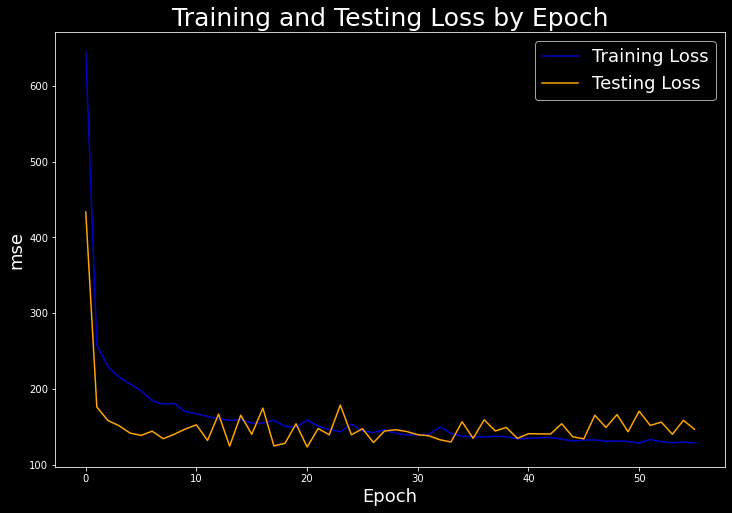

In [136]:
plt.style.use('dark_background')
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color=colors.to_rgba('b',0.8))
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('mse', fontsize = 18)

plt.legend(fontsize = 18);

In [137]:
model_file_path = './saved_models/'
this_filename = 'NN_2_5_6_10_4_20_5'
# NN depth, num_mins_behind, num minutes_yesterday, num_languages, num_games, num_locations, patience
new_model.save(model_file_path+this_filename)

INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_6_10_4_20_5\assets


In [138]:
total_rate_preds = new_model.predict(sliced_X_test)[:,0]
wordle_fraction_preds = new_model.predict(sliced_X_test)[:,1]

In [139]:
r2_score(y_test['total_tweets'],total_rate_preds), mean_squared_error(y_test['total_tweets'],total_rate_preds)

(0.49458636675877765, 196.6670082860201)

In [140]:
r2_score(y_test['is_wordle'],wordle_fraction_preds), mean_squared_error(y_test['is_wordle'],wordle_fraction_preds)

(0.2663537309672619, 97.13949134765201)

# Manual Gridsearch

Search over a range of these values.

In [157]:
sliced_X_train = slice_tweet_df(X_train, 10,10,10,10,10)
sliced_X_test = slice_tweet_df(X_test, 10,10,10,10,10)
new_model = create_tweets_NN(len(sliced_X_train.columns), 2)
new_model.fit(sliced_X_train,
            y_train,
            validation_data=(sliced_X_test, y_test),
            batch_size = 256,
            epochs = 2000,
            callbacks = [callback],
            verbose = True
           )

Epoch 1/2000
23/23 [==============================] - 1s 9ms/step - loss: 2037.4478 - val_loss: 795.3119
Epoch 2/2000
23/23 [==============================] - 0s 4ms/step - loss: 352.5300 - val_loss: 277.9650
Epoch 3/2000
23/23 [==============================] - 0s 4ms/step - loss: 228.0961 - val_loss: 167.0081
Epoch 4/2000
23/23 [==============================] - 0s 4ms/step - loss: 201.7724 - val_loss: 156.9685
Epoch 5/2000
23/23 [==============================] - 0s 4ms/step - loss: 190.6211 - val_loss: 137.0447
Epoch 6/2000
23/23 [==============================] - 0s 5ms/step - loss: 179.4471 - val_loss: 166.7010
Epoch 7/2000
23/23 [==============================] - 0s 5ms/step - loss: 179.9266 - val_loss: 125.6398
Epoch 8/2000
23/23 [==============================] - 0s 4ms/step - loss: 165.6378 - val_loss: 134.4911
Epoch 9/2000
23/23 [==============================] - 0s 3ms/step - loss: 160.8211 - val_loss: 141.1983
Epoch 10/2000
23/23 [==============================] - 0s 5ms/s

In [158]:
total_rate_preds = new_model.predict(sliced_X_test)[:,0]
wordle_fraction_preds = new_model.predict(sliced_X_test)[:,1]
r2_total = r2_score(y_test['total_tweets'],total_rate_preds)
mse_total = mean_squared_error(y_test['total_tweets'],total_rate_preds)
r2_wordle = r2_score(y_test['is_wordle'],wordle_fraction_preds)
mse_wordle = mean_squared_error(y_test['is_wordle'],wordle_fraction_preds)

In [179]:
r2_total, mse_total, r2_wordle, mse_wordle

(-2.0349490789923164, 1180.9621197553975, -2.525430403692968, 466.789692323782)

In [183]:
%%time

#keep track of scores and such
results=[]

for num_layers in [2,1,3]:
    for patience in [0,5,10]:
        for num_locations in [0,12,25]: #up to 25 top locations
            for num_games in [0,12,25]: #up to 25 top games
                for num_languages in [0, 10, 20]: #up to 20 languages columns
                    for num_minutes_yesterday in range(0,12,5): #0 to 20 minute window
                        for num_minutes_behind in range(0,12,5):  #up to 19 minutes behind
                            if num_languages == 0:
                                print(f'working on num_layers = {num_layers}, patience = {patience}, num_games = {num_games}, num_locations = {num_locations}')
                            callback = callbacks.EarlyStopping(monitor='loss', patience=patience)
                            sliced_X_train = slice_tweet_df(X_train, num_minutes_behind, num_minutes_yesterday, num_languages, num_games, num_locations)
                            sliced_X_test = slice_tweet_df(X_test, num_minutes_behind, num_minutes_yesterday, num_languages, num_games, num_locations)
                            new_model = create_tweets_NN(len(sliced_X_train.columns), num_layers)
                            history = new_model.fit(sliced_X_train,
                                                    y_train,
                                                    validation_data=(sliced_X_test, y_test),
                                                    batch_size = 32,
                                                    epochs = 1000,
                                                    callbacks = [callback],
                                                    verbose = False
                                                   )
                            #save the model
                            model_file_path = './saved_models/'
                            this_filename = f'NN_{num_layers}_{num_minutes_behind}_{num_minutes_yesterday}_{num_languages}_{num_games}_{num_locations}_{patience}'
                            # NN depth, num_mins_behind, num minutes_yesterday, num_languages, num_games, num_locations, patience
                            new_model.save(model_file_path+this_filename, overwrite=True)
                            #score model
                            total_rate_preds = new_model.predict(sliced_X_test)[:,0]
                            wordle_fraction_preds = new_model.predict(sliced_X_test)[:,1]
                            r2_total = r2_score(y_test['total_tweets'],total_rate_preds)
                            mse_total = mean_squared_error(y_test['total_tweets'],total_rate_preds)
                            r2_wordle = r2_score(y_test['is_wordle'],wordle_fraction_preds)
                            mse_wordle = mean_squared_error(y_test['is_wordle'],wordle_fraction_preds)
                            results.append([this_filename, r2_total, mse_total, r2_wordle, mse_wordle])
                            

working on num_layers = 2, patience = 0, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_0_0_0_0_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_0_0_0_0_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_0_0_0_0_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_5_0_0_0_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_5_0_0_0_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_5_0_0_0_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: .

INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_0_0_0_12_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_0_0_0_12_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_0_0_0_12_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_5_0_0_12_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_5_0_0_12_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_5_0_0_12_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_10_0_0_12_0\assets
working on num_layers 

working on num_layers = 2, patience = 0, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_0_0_0_25_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_0_0_0_25_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_0_0_0_25_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_5_0_0_25_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_5_0_0_25_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_5_0_0_25_0\assets
working on num_layers = 2, patience = 0, num_games = 0, num_locations = 25
INFO:tensorflow:Assets 

INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_10_20_25_25_0\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_0_0_0_0_5\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_0_0_0_0_5\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_0_0_0_0_5\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_5_0_0_0_5\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_5_0_0_0_5\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_5_0_0_0_5\assets
working on num_layers = 2, pati

working on num_layers = 2, patience = 5, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_0_0_0_12_5\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_0_0_0_12_5\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_0_0_0_12_5\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_5_0_0_12_5\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_5_0_0_12_5\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_5_0_0_12_5\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 12
INFO:tensorflow:Assets 

INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_10_20_25_12_5\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_0_0_0_25_5\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_0_0_0_25_5\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_0_0_0_25_5\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_5_0_0_25_5\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_5_0_0_25_5\assets
working on num_layers = 2, patience = 5, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_5_0_0_25_5\assets
working on num_laye

INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_10_20_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_10_20_25_25_5\assets
working on num_layers = 2, patience = 10, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_0_0_0_0_10\assets
working on num_layers = 2, patience = 10, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_0_0_0_0_10\assets
working on num_layers = 2, patience = 10, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_0_0_0_0_10\assets
working on num_layers = 2, patience = 10, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_5_0_0_0_10\assets
working on num_layers = 2, patience = 10, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_5_0_0_0_10\assets
working on num_layers = 2, patience = 10, num_games = 0, num_locations = 0
INFO:tensorflow:A

INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_10_20_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_10_20_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_10_20_25_0_10\assets
working on num_layers = 2, patience = 10, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_0_0_0_12_10\assets
working on num_layers = 2, patience = 10, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_0_0_0_12_10\assets
working on num_layers = 2, patience = 10, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_0_0_0_12_10\assets
working on num_layers = 2, patience = 10, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_5_0_0_12_10\assets
working on num_layers = 2, patience = 10, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_5_0_0_12_10\assets
work

INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_5_20_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_5_20_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_10_20_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_10_20_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_10_20_25_12_10\assets
working on num_layers = 2, patience = 10, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_0_0_0_25_10\assets
working on num_layers = 2, patience = 10, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_0_0_0_25_10\assets
working on num_layers = 2, patience = 10, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_0_0_0_25_10\assets
working on num_layers = 2, patience = 10, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_5_0_0_25_10\ass

INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_0_20_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_5_20_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_5_20_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_5_20_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_2_0_10_20_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_2_5_10_20_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_2_10_10_20_25_25_10\assets
working on num_layers = 1, patience = 0, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_0_0_0_0_0\assets
working on num_layers = 1, patience = 0, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_0_0_0_0_0\assets
working on num_layers = 1, patience = 0, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_0_0_0_0_0\assets
wor

INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_5_20_25_0_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_5_20_25_0_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_5_20_25_0_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_10_20_25_0_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_10_20_25_0_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_10_20_25_0_0\assets
working on num_layers = 1, patience = 0, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_0_0_0_12_0\assets
working on num_layers = 1, patience = 0, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_0_0_0_12_0\assets
working on num_layers = 1, patience = 0, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_0_0_0_12_0\assets
working on num_layers = 1, patience = 0, num_games = 0, num_locations = 12
INFO:tensorfl

INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_0_20_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_5_20_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_5_20_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_5_20_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_10_20_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_10_20_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_10_20_25_12_0\assets
working on num_layers = 1, patience = 0, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_0_0_0_25_0\assets
working on num_layers = 1, patience = 0, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_0_0_0_25_0\assets
working on num_layers = 1, patience = 0, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_0_0_0_25_0\assets
work

INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_0_20_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_0_20_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_5_20_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_5_20_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_5_20_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_10_20_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_10_20_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_10_20_25_25_0\assets
working on num_layers = 1, patience = 5, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_0_0_0_0_5\assets
working on num_layers = 1, patience = 5, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_0_0_0_0_5\assets
working on num_layers = 1, patience = 5, num_games = 0, num_locations = 0
INFO:ten

INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_0_20_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_5_20_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_5_20_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_5_20_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_10_20_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_10_20_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_10_20_25_0_5\assets
working on num_layers = 1, patience = 5, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_0_0_0_12_5\assets
working on num_layers = 1, patience = 5, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_0_0_0_12_5\assets
working on num_layers = 1, patience = 5, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_0_0_0_12_5\assets
working on 

INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_0_20_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_0_20_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_5_20_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_5_20_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_5_20_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_10_20_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_10_20_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_10_20_25_12_5\assets
working on num_layers = 1, patience = 5, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_0_0_0_25_5\assets
working on num_layers = 1, patience = 5, num_games = 0, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_0_0_0_25_5\assets
working on num_layers = 1, patience = 5, num_games = 0, num_locations = 25
INF

INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_0_20_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_0_20_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_0_20_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_5_20_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_5_20_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_5_20_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_10_20_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_10_20_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_10_20_25_25_5\assets
working on num_layers = 1, patience = 10, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_0_0_0_0_10\assets
working on num_layers = 1, patience = 10, num_games = 0, num_locations = 0
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_0_0_0_0_10\assets
w

INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_10_10_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_0_20_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_0_20_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_0_20_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_5_20_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_5_20_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_5_20_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_10_20_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_10_20_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_10_20_25_0_10\assets
working on num_layers = 1, patience = 10, num_games = 0, num_locations = 12
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_0_0_0_12_10\assets
working on num_layers = 1, patience = 10, num_games = 0, num_locations

INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_10_10_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_10_10_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_10_10_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_0_20_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_0_20_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_0_20_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_5_20_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_5_20_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_5_20_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_10_20_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_10_20_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_10_20_25_12_10\assets
working on num_layers = 1, patience = 10, num_games = 

INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_5_10_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_5_10_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_10_10_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_10_10_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_10_10_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_0_20_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_0_20_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_0_20_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_5_20_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5_5_20_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_10_5_20_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_0_10_20_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_1_5

INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_5_10_25_0_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_5_10_25_0_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_10_10_25_0_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_10_10_25_0_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_10_10_25_0_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_0_20_25_0_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_0_20_25_0_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_0_20_25_0_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_5_20_25_0_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_5_20_25_0_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_5_20_25_0_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_10_20_25_0_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_10_20_25_0_0\assets
INF

INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_5_10_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_5_10_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_10_10_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_10_10_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_10_10_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_0_20_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_0_20_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_0_20_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_5_20_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_5_20_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_5_20_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_10_20_25_12_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_10_20_25_12

INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_5_10_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_5_10_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_5_10_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_10_10_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_10_10_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_10_10_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_0_20_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_0_20_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_0_20_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_5_20_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_5_20_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_5_20_25_25_0\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_10_20_25_25_

INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_5_10_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_5_10_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_10_10_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_10_10_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_10_10_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_0_20_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_0_20_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_0_20_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_5_20_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_5_20_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_5_20_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_10_20_25_0_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_10_20_25_0_5\assets
INF

INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_5_10_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_5_10_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_10_10_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_10_10_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_10_10_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_0_20_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_0_20_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_0_20_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_5_20_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_5_20_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_5_20_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_10_20_25_12_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_10_20_25_12

INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_5_10_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_5_10_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_5_10_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_10_10_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_10_10_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_10_10_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_0_20_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_0_20_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_0_20_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_5_20_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_5_20_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_5_20_25_25_5\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_10_20_25_25_

INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_0_10_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_5_10_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_5_10_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_5_10_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_10_10_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_10_10_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_10_10_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_0_20_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_0_20_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_0_20_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_5_20_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_5_20_25_0_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_5_20_25_0_1

INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_0_10_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_0_10_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_0_10_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_5_10_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_5_10_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_5_10_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_10_10_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_10_10_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_10_10_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_0_20_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_0_20_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_0_20_25_12_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_

working on num_layers = 3, patience = 10, num_games = 25, num_locations = 25
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_10_0_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_0_10_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_0_10_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_0_10_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_5_10_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_5_10_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_5_10_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_10_10_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_10_10_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_10_10_10_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_0_0_20_25_25_10\assets
INFO:tensorflow:Assets written to: ./saved_models/NN_3_5_0

In [184]:
pd.DataFrame(results).to_csv('./NNresults.csv')

In [185]:
type(results)

list

In [186]:
len(results)

2187

In [218]:
r2s_total = np.array(results)[:,1].astype(float)
r2s_wordle = np.array(results)[:,3].astype(float)

In [219]:
r2s_total.max(), r2s_wordle.max()

(0.7478634846457892, 0.5475777851974112)

(0.0, 1.0)

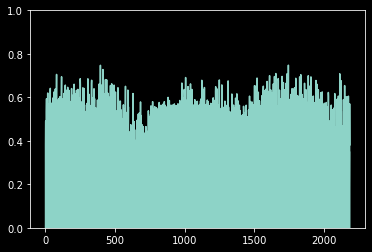

In [220]:
plt.plot(r2s_total)
plt.ylim(0,1)

(0.0, 1.0)

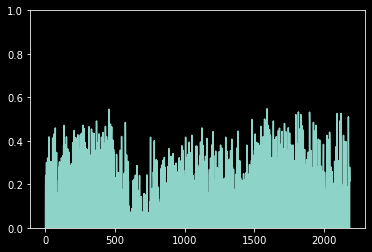

In [214]:
plt.plot(r2s_wordle)
plt.ylim(0,1)

Text(0, 0.5, 'r2s total')

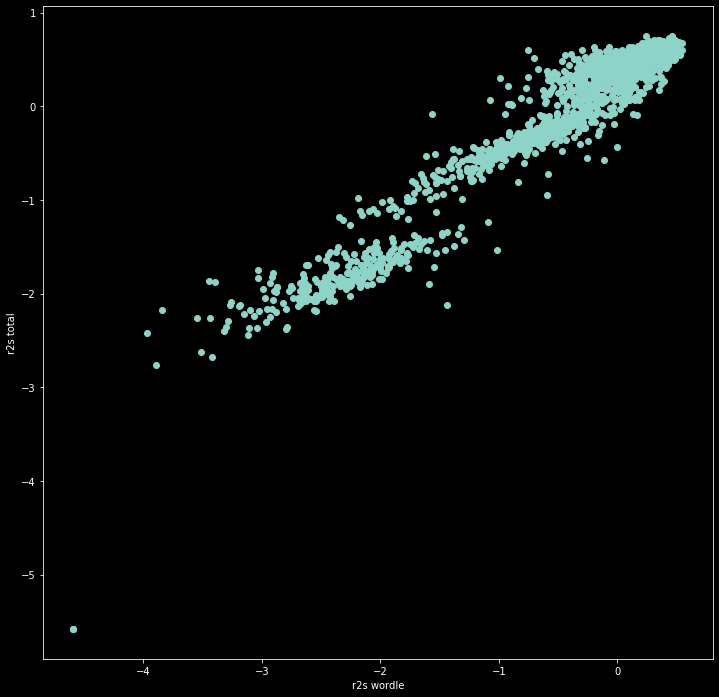

In [222]:
plt.figure(figsize = (12,12))
plt.scatter(r2s_wordle, r2s_total)
plt.xlabel('r2s wordle')
plt.ylabel('r2s total')

(0.0, 1.0)

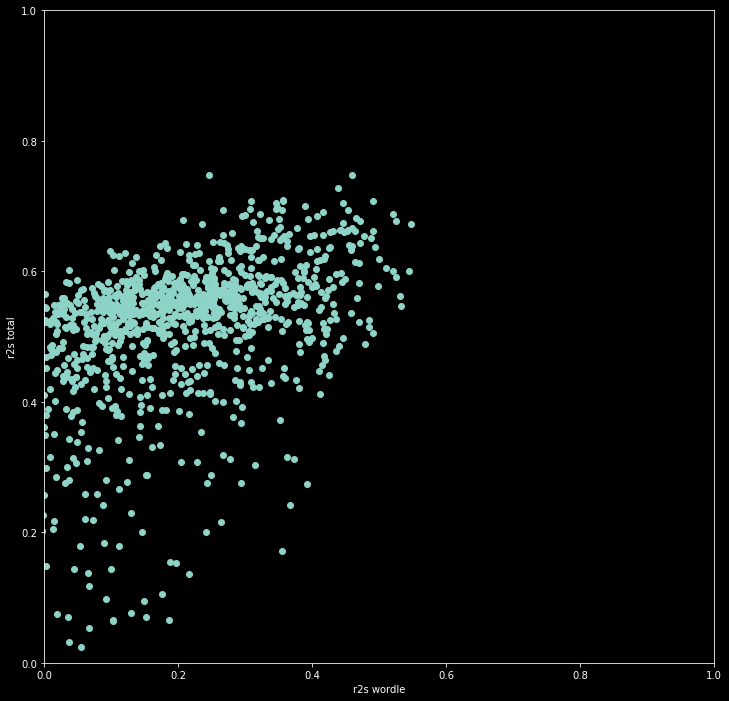

In [223]:
plt.figure(figsize = (12,12))
plt.scatter(r2s_wordle, r2s_total)
plt.xlabel('r2s wordle')
plt.ylabel('r2s total')
plt.xlim(0,1)
plt.ylim(0,1)

# Compare to a 10-minute lagged 